# Regulatory Network Analysis of All Neutrophils Using pySCENIC
*Jiayu Su, 09/23/2019*

**The following pipeline consists of three parts:**
1. Estimate co-expression modules
2. Trim co-expression modules into regulons
3. Calculate AUCell scores for each regulon in each cell

Note that we scaled the network inference (step 1&2) by first inferring regulons on a 6000-cell subset, then calculate AUCell scores for all 32888 cells included in this analysis.

**Input:**
1. TFs and their binding motifs:https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.mgi-m0.001-o0.0.tbl
2. cisTarget databases:https://resources.aertslab.org/cistarget/
3. The expression profile (although it's mentioned in their paper that SCENIC result is robust to normalization, raw count data was used in this pipeline).

**Output:**
1. A dataframe containing the information of *r* regulons 
2. A *r-by-n* AUCell score matrix

### Load required packages, set working directory and load resource files

**Please make sure you have the latest version of SCENIC installed from GitHub.** 
<br>
Previous versions contain unexpected bugs.

In [2]:
import pandas as pd
import numpy as np
import os, glob
import pickle

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns

C:\Users\0rient\Anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:
DATA_FOLDER="E:\\SCENIC\\Integrated_Results"
RESOURCES_FOLDER="E:\\SCENIC\\resources"
DATABASE_FOLDER = "E:\\SCENIC\\database"

DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "mm*.mc9nr.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl.txt")

MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'mm_tfs.txt')
SC_EXP_FNAME = os.path.join(DATA_FOLDER, "Mat4GRN.csv")

## Files that store intermediate results
ADJACENCIES_FNAME = os.path.join(DATA_FOLDER, "adjacencies.tsv")
MODULES_FNAME = os.path.join(DATA_FOLDER, "modules.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")

### Step 0: Load data

In [3]:
# load TF names
tf_names = load_tf_names(MM_TFS_FNAME)

In [26]:
# load count matrix
ex_matrix = pd.read_csv(SC_EXP_FNAME, header=0, index_col=0).T

In [5]:
ex_matrix.shape

(6000, 13217)

In [7]:
ex_matrix.head()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,Adhfe1,...,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7,Tmlhe,Csprs,AC125149.3,AC125149.2,AC168977.1,CAAA01147332.1
wt.ctl.bm1_AAACCTGGTCTTGCGG,4,1,1,0,0,0,3,0,2,0,...,9,0,58,0,0,0,0,0,0,0
wt.ctl.bm1_AAACGGGAGGTACTCT,4,0,2,3,0,0,1,0,4,0,...,9,0,74,0,0,0,0,0,0,0
wt.ctl.bm1_AAAGATGGTACTTCTT,0,0,1,0,0,0,0,0,1,0,...,0,0,16,0,0,0,0,0,0,0
wt.ctl.bm1_AAAGATGGTATGAAAC,4,0,1,1,3,0,0,0,6,0,...,3,0,95,0,0,0,0,0,0,0
wt.ctl.bm1_AAAGATGGTCTCCACT,0,0,0,0,1,0,0,0,1,0,...,0,0,11,0,0,0,0,0,0,0


In [5]:
# load ranking database
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.basename(fname).split(".")[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]

In [6]:
dbs

[FeatherRankingDatabase(name="mm10__refseq-r80__500bp_up_and_100bp_down_tss"),
 FeatherRankingDatabase(name="mm9-500bp-upstream-10species"),
 FeatherRankingDatabase(name="mm9-500bp-upstream-7species"),
 FeatherRankingDatabase(name="mm9-tss-centered-10kb-7species"),
 FeatherRankingDatabase(name="mm9-tss-centered-5kb-7species")]

In [7]:
# remove unwanted databases
dbs = [dbs[0], dbs[1], dbs[3]]
dbs

[FeatherRankingDatabase(name="mm10__refseq-r80__500bp_up_and_100bp_down_tss"),
 FeatherRankingDatabase(name="mm9-500bp-upstream-10species"),
 FeatherRankingDatabase(name="mm9-tss-centered-10kb-7species")]

### Step 1: Estimate co-expression modules

#### 1) Detect co-expression modules

**Estimated execution time**: 5h for ~2000 cells with 20000 genes (Intel Core i7-6700HQ CPU), reducing the number of genes would certainly help.

In [27]:
adjacencies = grnboost2(expression_data=ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input


C:\Users\0rient\Anaconda3\lib\site-packages\arboreto\algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster
finished


In [28]:
adjacencies.shape

(4928083, 3)

In [29]:
# save intermediate results
adjacencies.to_csv(ADJACENCIES_FNAME, index=False, sep='\t')

#### 2) Derive potential regulons from these co-expression modules

In [30]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))

C:\Users\0rient\Anaconda3\lib\site-packages\pyscenic\utils.py:138: RuntimeWarning: invalid value encountered in greater
  regulations = (rhos > rho_threshold).astype(int) - (rhos < -rho_threshold).astype(int)
C:\Users\0rient\Anaconda3\lib\site-packages\pyscenic\utils.py:138: RuntimeWarning: invalid value encountered in less
  regulations = (rhos > rho_threshold).astype(int) - (rhos < -rho_threshold).astype(int)


In [31]:
len(modules)

5334

In [3]:
# save intermediate results
with open(MODULES_FNAME, 'wb') as f:
    pickle.dump(modules, f)

## read in existing intermediate results
#with open(MODULES_FNAME, 'rb') as f:
#    modules = pickle.load(f)

### Step 2: Trim co-expression modules into regulons

**Estimated execution time**: 3h (Intel Core i7-6700HQ CPU).

In [8]:
# cisTarget databases used to prune regulons
dbs

[FeatherRankingDatabase(name="mm10__refseq-r80__500bp_up_and_100bp_down_tss"),
 FeatherRankingDatabase(name="mm9-500bp-upstream-10species"),
 FeatherRankingDatabase(name="mm9-tss-centered-10kb-7species")]

In [9]:
df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

In [6]:
df.head()

Enrichment  \
                                                             AUC   
TF       MotifID                                                   
AU041133 dbcorrdb__MYC__ENCSR000EZU_1__m1               0.059135   
         dbcorrdb__MXI1__ENCSR000EIA_1__m1              0.059316   
         homer__GNCCACGTGG_n-Myc                        0.059583   
         dbcorrdb__MYC__ENCSR000DLZ_1__m1               0.058963   
Ascl2    taipale_cyt_meth__MYOD1_NAACANNTGTYN_FL_meth   0.060320   

                                                                                                          \
                                                                                              Annotation   
TF       MotifID                                                                                           
AU041133 dbcorrdb__MYC__ENCSR000EZU_1__m1              motif similar to transfac_pro__M06039 ('V$ZNF8...   
         dbcorrdb__MXI1__ENCSR000EIA_1__m1             motif similar to transfac_pro__M06039 ('V$ZNF8...   
         homer__GNCCACGTGG_n-Myc                       motif similar to transfac_pro__M06039 ('V$ZNF8...   
         dbcorrdb__MYC__ENCSR000DLZ_1__m1              motif similar to transfac_pro__M06039 ('V$ZNF8...   
Ascl2    taipale_cyt_meth__MYOD1_NAACANNTGTYN_FL_meth  gene is annotated for similar motif cisbp__M01...   

                                                                                                          \
                                                                                                 Context   
TF       MotifID                                                                                           
AU041133 dbcorrdb__MYC__ENCSR000EZU_1__m1              (mm10__refseq-r80__500bp_up_and_100bp_down_tss...   
         dbcorrdb__MXI1__ENCSR000EIA_1__m1             (mm10__refseq-r80__500bp_up_and_100bp_down_tss...   
         homer__GNCCACGTGG_n-Myc                       (mm10__refseq-r80__500bp_up_and_100bp_down_tss...   
         dbcorrdb__MYC__ENCSR000DLZ_1__m1              (mm10__refseq-r80__500bp_up_and_100bp_down_tss...   
Ascl2    taipale_cyt_meth__MYOD1_NAACANNTGTYN_FL_meth  (mm10__refseq-r80__500bp_up_and_100bp_down_tss...   

                                                                             \
                                                      MotifSimilarityQvalue   
TF       MotifID                                                              
AU041133 dbcorrdb__MYC__ENCSR000EZU_1__m1                          0.000366   
         dbcorrdb__MXI1__ENCSR000EIA_1__m1                         0.000242   
         homer__GNCCACGTGG_n-Myc                                   0.000492   
         dbcorrdb__MYC__ENCSR000DLZ_1__m1                          0.000773   
Ascl2    taipale_cyt_meth__MYOD1_NAACANNTGTYN_FL_meth              0.000249   

                                                                 \
                                                            NES   
TF       MotifID                                                  
AU041133 dbcorrdb__MYC__ENCSR000EZU_1__m1              3.041614   
         dbcorrdb__MXI1__ENCSR000EIA_1__m1             3.060032   
         homer__GNCCACGTGG_n-Myc                       3.087222   
         dbcorrdb__MYC__ENCSR000DLZ_1__m1              3.024072   
Ascl2    taipale_cyt_meth__MYOD1_NAACANNTGTYN_FL_meth  3.020315   

                                                                           \
                                                      OrthologousIdentity   
TF       MotifID                                                            
AU041133 dbcorrdb__MYC__ENCSR000EZU_1__m1                         0.47081   
         dbcorrdb__MXI1__ENCSR000EIA_1__m1                        0.47081   
         homer__GNCCACGTGG_n-Myc                                  0.47081   
         dbcorrdb__MYC__ENCSR000DLZ_1__m1                         0.47081   
Ascl2    taipale_cyt_meth__MYOD1_NAACANNTGTYN_FL_meth             1.00

In [11]:
# save intermediate results
df.to_csv(MOTIFS_FNAME)

## read in existing intermediate results
#from pyscenic.utils import load_motifs
#df = load_motifs(MOTIFS_FNAME)

**Ignore the following cell if you have the latest version of pySCENIC installed.** <br>There is a bug in the `df2regulons` function in the version I worked with, which is now fixed in the latest version. 

In [12]:
from pyscenic.genesig import Regulon
from functools import reduce
import math
def df2regulons(df):
    """
    Create regulons from a dataframe of enriched features.
    :param df: The dataframe.
    :return: A sequence of regulons.
    """

    # Because the code below will alter the dataframe we need to make a defensive copy of it.
    df = df.copy()

    # Normally the columns index has two levels. For convenience of the following code the first level is removed.
    if df.columns.nlevels == 2:
        df.columns = df.columns.droplevel(0)

    # Unpack the type of the module from the context column (dtype = frozenset)
    def text(row):
        return "activating"
    df["Type"] = df.apply(text,axis=1)

    # Group all rows per TF and type (+)/(-). Each group results in a single regulon.
    not_none = lambda r: r is not None
    return list(filter(not_none, (_regulon4group(tf_name, frozenset([interaction_type]), df_grp)
                                  for (tf_name, interaction_type), df_grp in df.groupby(by=["TF","Type"]))))

def _regulon4group(tf_name, context, df_group):
    def score(nes, motif_similarity_qval, orthologuous_identity):
        # The combined score starts from the NES score which is then corrected for less confidence in the TF annotation
        # in two steps:
        # 1. The orthologous identifity (a fraction between 0 and 1.0) is used directly to normalize the NES.
        # 2. The motif similarity q-value is converted to a similar fraction: -log10(q-value)
        # A motif that is directly annotated for the TF in the correct species is not penalized.

        correction_fraction = 1.0
        try:
            max_value = 10  # A q-value smaller than 10**-10 is considered the same as a q-value of 0.0.
            correction_fraction = min(-math.log(motif_similarity_qval, 10), max_value)/max_value if not math.isnan(motif_similarity_qval) else 1.0
        except ValueError: # Math domain error
            pass
        score = nes * correction_fraction

        # We assume that a non existing orthologous identity signifies a direct annotation.
        return score if math.isnan(orthologuous_identity) else score * orthologuous_identity

    def derive_interaction_type(ctx):
        return "(+)"

    def row2regulon(row):
        # The target genes as well as their weights/importances are directly taken from the dataframe.
        return Regulon(name="{}{}".format(tf_name,derive_interaction_type(context)),
                        score=score(row["NES"],
                                    row["MotifSimilarityQvalue"],
                                    row["OrthologousIdentity"]),
                        context=context,
                        transcription_factor=tf_name,
                        gene2weight=row["TargetGenes"])

    # Find most enriched annotated motif and add this to the context.
    df_selected = df_group.sort_values(by="NES", ascending=False)
    motif_logo = '{}.png'.format(df_selected.head(1).reset_index()["MotifID"].values[0]) if len(df_selected) > 0 else ""

    # First we create a regulon for each enriched and annotated feature and then we aggregate these regulons into a
    # single one using the union operator. This operator combined all target genes into a single set of genes keeping
    # the maximum weight associated with a gene. In addition, the maximum combined score is kept as the score of the
    # entire regulon.
    return reduce(Regulon.union, (row2regulon(row) for _, row in df_group.iterrows())).copy(context=frozenset(set(context).union({motif_logo})))

In [13]:
regulons = df2regulons(df)

In [14]:
len(regulons)

412

In [15]:
regulons[3]

Regulon(name='AU041133(+)', gene2weight=<frozendict {'Rnf145': 0.324625365550818, 'Ddx42': 4.680087584293777, 'BC048403': 0.509689155567759, 'Nras': 1.0, 'Ppfia4': 1.0, 'Sfxn2': 4.680087584293777, 'Scfd2': 4.680087584293777, 'Cln3': 2.6064726293332163, 'Stk4': 4.680087584293777, 'Nle1': 1.1602094043025566, 'Mlh3': 0.48072968246660575, 'Slc39a14': 2.6064726293332163, '2900026A02Rik': 0.509689155567759, 'Gnptg': 1.0, 'Plekhg3': 0.666940365482154, 'Sgms1': 0.509689155567759, 'Dhrs3': 0.49366842477090384, 'Mapk8': 2.780056688935559, 'Camta1': 0.508605803665131, 'Prpf3': 1.0746475746948057, 'A230050P20Rik': 0.6324947786389252, 'Adcy3': 1.1602094043025566, 'Nmb': 0.7261966645780417, 'Plec': 4.680087584293777, 'Pfkfb3': 2.6064726293332163, 'Pex10': 0.9491381150173994, 'Grb10': 0.48072968246660575, 'Wipf1': 0.3197731713394423, 'Stard8': 0.49366842477090384, 'Znfx1': 0.508605803665131, 'Adamts10': 1.0746475746948057, 'Plxdc1': 0.6324947786389252, 'Pptc7': 0.6472647767544734, 'Cdc42ep4': 0.58048

In [33]:
# save regulons as a pickle object which can only be used in python
with open(REGULONS_FNAME, 'wb') as f:
    pickle.dump(regulons, f)

In [32]:
regulons[2].gene2weight

<frozendict {'Baz2a': 1.0, 'Rbl2': 1.8801812318731694, 'Nacc1': 3.0842801631616616, 'Zfp668': 1.1086545244599368, 'Fbxo5': 3.171577802796261, 'Psmc3ip': 0.6989058018669674, 'Map3k9': 3.9018367995739385, 'Hist2h2ab': 1.365159891803252, 'Lrrc8b': 1.8560315515025163, 'Lmo1': 2.3897268346220537, 'Hist1h3b': 1.2702784601236305, 'Adcy9': 0.8287821600232227}>

In [43]:
# save regulons in a txt file
with open(os.path.join(DATA_FOLDER, 'regulons_weights.new.txt'), 'w') as f:
    for item in regulons:
        f.write(f"{item.name}\t{item.transcription_factor}\t{item.context}\t{item.score}\t{len(item.gene2weight)}\t{item.gene2weight}\n")

In [40]:
with open(os.path.join(DATA_FOLDER, 'regulons_genes.txt'), 'w') as f:
    for item in regulons:
        f.write(f"{item.name}\t{len(item.gene2weight)}\n")
        for dst_name, edge_strength in item.gene2weight.items():
            f.write(f"{dst_name}\n")
        f.write("\n")

### Step 3: Calculate AUCell scores for each regulon in each cell

#### 1) Perform AUCell on selected cells

In [27]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=1)

100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [00:21<00:00, 19.05it/s]


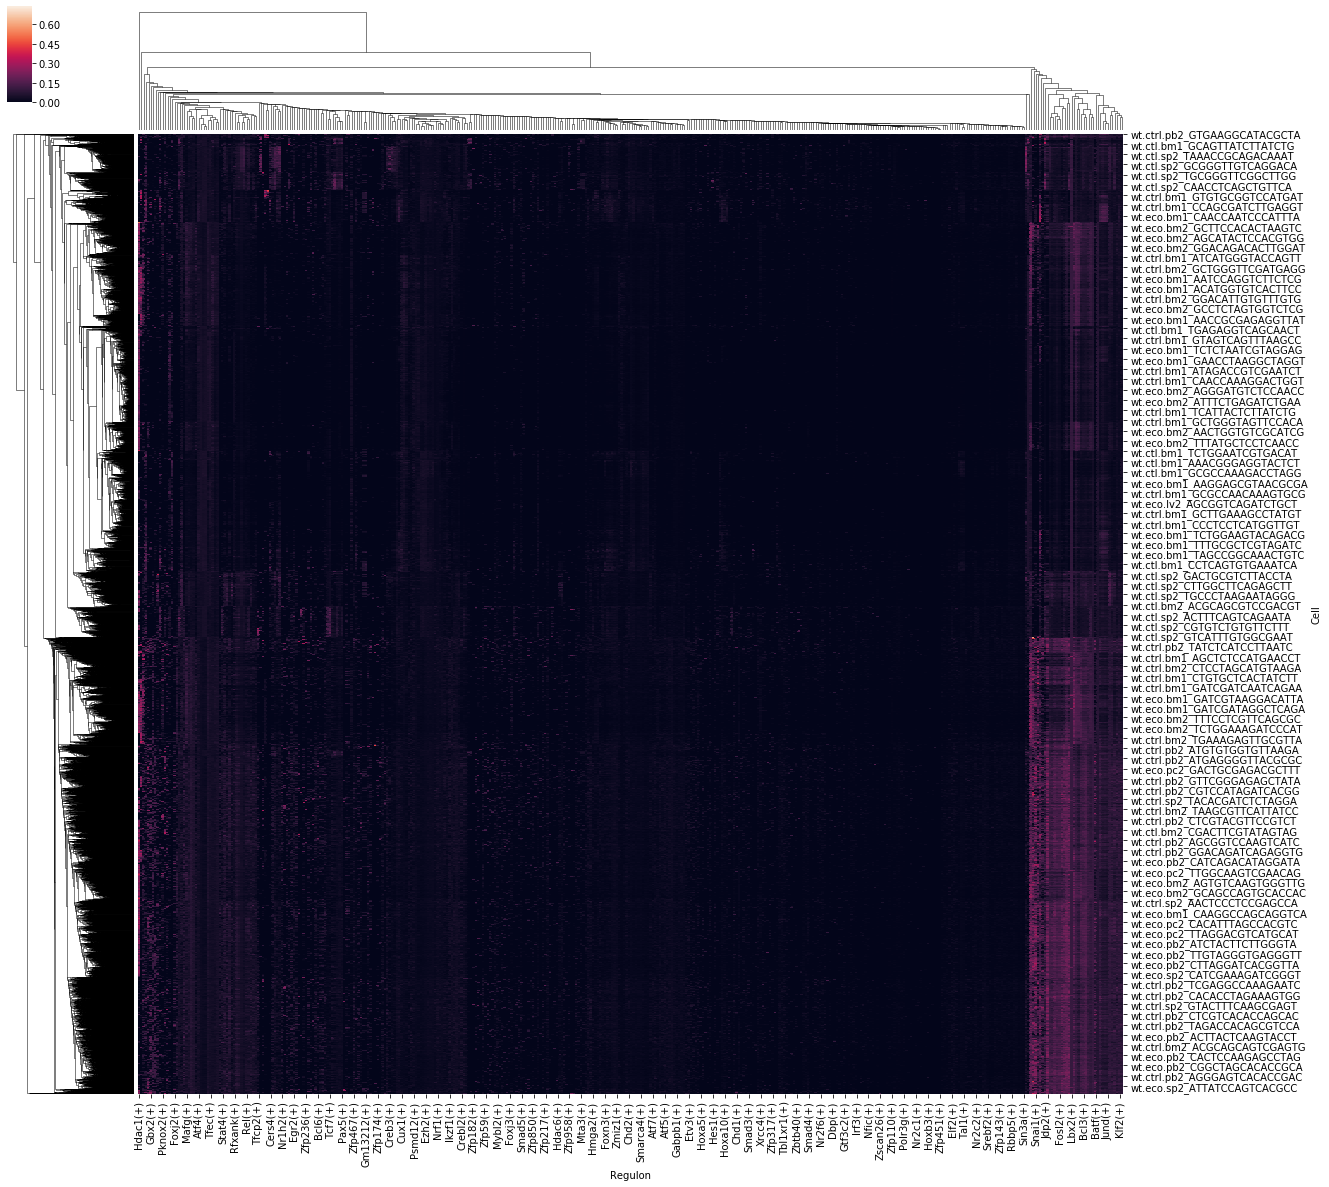

In [28]:
sns.clustermap(auc_mtx, figsize=(20,20))

In [29]:
auc_mtx.head()

Regulon,1810024B03Rik(+),2010315B03Rik(+),9130023H24Rik(+),AU041133(+),AW146154(+),Aco1(+),Ahr(+),Arid3a(+),Ascl2(+),Atf1(+),...,Zfp930(+),Zfp931(+),Zfp94(+),Zfp958(+),Zfp959(+),Zkscan3(+),Zkscan7(+),Zmiz1(+),Zscan2(+),Zscan26(+)
Cell,,,,,,,,,,,,,,,,,,,,,
wt.ctl.bm1_AAACCTGGTCTTGCGG,0.0,0.000000,0.0,0.000000,0.059372,0.033542,0.000000,0.000000,0.000000,0.010132,...,0.039042,0.0,0.000000,0.000000,0.0,0.0,0.0,0.008543,0.0,0.0
wt.ctl.bm1_AAACGGGAGGTACTCT,0.0,0.000000,0.0,0.000000,0.066437,0.000654,0.000000,0.000000,0.000000,0.009471,...,0.066799,0.0,0.000000,0.000000,0.0,0.0,0.0,0.007481,0.0,0.0
wt.ctl.bm1_AAAGATGGTACTTCTT,0.0,0.000000,0.0,0.004227,0.000000,0.021481,0.000000,0.000000,0.016249,0.002951,...,0.052502,0.0,0.018397,0.092311,0.0,0.0,0.0,0.021911,0.0,0.0
wt.ctl.bm1_AAAGATGGTATGAAAC,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.050063,0.000000,0.003376,...,0.045801,0.0,0.000000,0.000000,0.0,0.0,0.0,0.003183,0.0,0.0
wt.ctl.bm1_AAAGATGGTCTCCACT,0.0,0.030921,0.0,0.013621,0.000000,0.003982,0.041749,0.000000,0.012853,0.004711,...,0.001047,0.0,0.000000,0.056462,0.0,0.0,0.0,0.017512,0.0,0.0


In [31]:
# save the auc matrix
auc_mtx.to_csv(os.path.join(DATA_FOLDER, "AUC_mtx_Cells4GRN.csv"))

#### 2) Perform AUCell on all cells

In [6]:
# read in existing regulon files
#with open(REGULONS_FNAME, 'rb') as f:
#    regulons = pickle.load(f)

In [6]:
len(regulons)

412

In [19]:
# Loading wt dataset
T_EXP_FNAME = os.path.join(DATA_FOLDER, "merge_ref_wt.csv")
t_matrix = pd.read_csv(T_EXP_FNAME, header=0, index_col=0).T

In [25]:
# Loading challenged dataset
T_EXP_FNAME = os.path.join(DATA_FOLDER, "merge_ref_ecoli.csv")
t_matrix = pd.read_csv(T_EXP_FNAME, header=0, index_col=0).T

In [31]:
# Loading non-Neu dataset
T_EXP_FNAME = os.path.join(DATA_FOLDER, "merge_ref_nneu.csv")
t_matrix = pd.read_csv(T_EXP_FNAME, header=0, index_col=0).T

In [32]:
t_matrix.shape

(8163, 13217)

In [33]:
t_matrix.head()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,Adhfe1,...,mt-Nd5,mt-Nd6,mt-Cytb,Vamp7,Tmlhe,Csprs,AC125149.3,AC125149.2,AC168977.1,CAAA01147332.1
wt.ctl.bm1_AAACCTGAGCCCAACC,6,0,0,0,0,0,1,0,3,0,...,10,2,128,2,0,0,0,0,0,0
wt.ctl.bm1_AAACCTGCACCAGGCT,3,1,2,1,2,0,0,0,3,0,...,5,0,88,0,0,0,0,0,0,0
wt.ctl.bm1_AAACCTGCATGCATGT,0,0,0,0,1,0,0,0,0,0,...,0,0,17,0,0,0,0,0,0,0
wt.ctl.bm1_AAACCTGGTCCATGAT,0,0,1,0,1,0,0,0,0,0,...,0,0,23,0,0,0,0,0,0,0
wt.ctl.bm1_AAACCTGGTCTTGCGG,4,1,1,0,0,0,3,0,2,0,...,9,0,58,0,0,0,0,0,0,0


In [34]:
auc_mtx = aucell(t_matrix, regulons, num_workers=1)

100%|████████████████████████████████████████████████████████████████████████████████| 412/412 [00:25<00:00, 16.42it/s]


In [35]:
auc_mtx.head()

Regulon,1810024B03Rik(+),2010315B03Rik(+),9130023H24Rik(+),AU041133(+),AW146154(+),Aco1(+),Ahr(+),Arid3a(+),Ascl2(+),Atf1(+),...,Zfp930(+),Zfp931(+),Zfp94(+),Zfp958(+),Zfp959(+),Zkscan3(+),Zkscan7(+),Zmiz1(+),Zscan2(+),Zscan26(+)
Cell,,,,,,,,,,,,,,,,,,,,,
wt.ctl.bm1_AAACCTGAGCCCAACC,0.0,0.0,0.0,0.000000,0.000000,0.027445,0.0,0.000000,0.0,0.002811,...,0.049842,0.0,0.0,0.0,0.0,0.0,0.0,0.007213,0.0,0.0
wt.ctl.bm1_AAACCTGCACCAGGCT,0.0,0.0,0.0,0.000000,0.000000,0.016667,0.0,0.000000,0.0,0.002824,...,0.042182,0.0,0.0,0.0,0.0,0.0,0.0,0.003046,0.0,0.0
wt.ctl.bm1_AAACCTGCATGCATGT,0.0,0.0,0.0,0.001375,0.023798,0.000000,0.0,0.000000,0.0,0.001780,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.015906,0.0,0.0
wt.ctl.bm1_AAACCTGGTCCATGAT,0.0,0.0,0.0,0.009021,0.000000,0.005760,0.0,0.063287,0.0,0.007594,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.015206,0.0,0.0
wt.ctl.bm1_AAACCTGGTCTTGCGG,0.0,0.0,0.0,0.000000,0.060983,0.033750,0.0,0.000000,0.0,0.008738,...,0.032715,0.0,0.0,0.0,0.0,0.0,0.0,0.009018,0.0,0.0


#### 3) Save AUCell matrices

In [24]:
AUC_FNAME = os.path.join(DATA_FOLDER, "AUC_mtx_wt.csv")
auc_mtx.to_csv(AUC_FNAME)

In [30]:
AUC_FNAME = os.path.join(DATA_FOLDER, "AUC_mtx_ecoli.csv")
auc_mtx.to_csv(AUC_FNAME)

In [36]:
AUC_FNAME = os.path.join(DATA_FOLDER, "AUC_mtx_nneu.csv")
auc_mtx.to_csv(AUC_FNAME)

### Step 4: Export pySCENIC results in loom files (Optional: only for SCope visualization)

In [44]:
from pyscenic.export import export2loom

In [45]:
LOOM_FNAME = os.path.join(DATA_FOLDER, "regulon.loom")
ANNO_FNAME = os.path.join(DATA_FOLDER, "cell.info.csv")
AUC_FNAME = os.path.join(DATA_FOLDER, "AUC_mtx.csv")

In [47]:
regulons = [r.rename(r.name.replace('(',' (')) for r in regulons]

In [46]:
regulons[1]

Regulon(name='AI987944(+)', gene2weight=<frozendict {'Nfia': 4.052538721179961, 'Col5a1': 4.052538721179961, 'Lin54': 1.8333958135362414, 'Ckm': 3.7040260484061482, 'Nmnat3': 1.4959699828320583}>, transcription_factor='AI987944', context=frozenset({'', 'activating'}), score=0.541204580192084)

In [46]:
auc_mtx = pd.read_csv(AUC_FNAME, header=0, index_col=0)

In [62]:
auc_mtx.head()

Regulon,6720489N17Rik (+),AI987944 (+),Ahr (+),Arid3a (+),Arnt (+),Arntl (+),Atf1 (+),Atf2 (+),Atf3 (+),Atf4 (+),...,Zfp821 (+),Zfp825 (+),Zfp868 (+),Zfp932 (+),Zfp938 (+),Zfp949 (+),Zfp950 (+),Zfp951 (+),Zkscan14 (+),Zmiz1 (+)
Cell,,,,,,,,,,,,,,,,,,,,,
wt.ctrl.bm1_AAACCTGAGCCCAACC,0.0,0.0,0.000000,0.009834,0.0,0.013960,0.015261,0.001000,0.020367,0.031238,...,0.000000,0.0,0.000000,0.0,0.000000,0.012432,0.000000,0.008102,0.0,0.006174
wt.ctrl.bm1_AAACCTGAGCCCAGCT,0.0,0.0,0.056742,0.143572,0.0,0.000000,0.036184,0.016301,0.181007,0.028355,...,0.082641,0.0,0.000000,0.0,0.022864,0.060970,0.043786,0.000000,0.0,0.007003
wt.ctrl.bm1_AAACCTGAGCGCCTTG,0.0,0.0,0.000000,0.021679,0.0,0.018190,0.036058,0.006457,0.028504,0.029051,...,0.000000,0.0,0.085785,0.0,0.008889,0.022513,0.046574,0.006984,0.0,0.012438
wt.ctrl.bm1_AAACCTGCACCAGGCT,0.0,0.0,0.000000,0.008670,0.0,0.009871,0.017752,0.000963,0.015617,0.029616,...,0.000000,0.0,0.000000,0.0,0.000000,0.009321,0.000000,0.013331,0.0,0.004005
wt.ctrl.bm1_AAACCTGCAGCCTTTC,0.0,0.0,0.009583,0.157785,0.0,0.001637,0.025548,0.012741,0.116537,0.033804,...,0.052878,0.0,0.000000,0.0,0.026231,0.046212,0.128000,0.000000,0.0,0.010578


In [48]:
def is_valid_exp_matrix(mtx):
    return (all(isinstance(idx, str) for idx in mtx.index) 
            and all(isinstance(idx, str) for idx in mtx.columns)
            and (mtx.index.nlevels == 1)
            and (mtx.columns.nlevels == 1))

In [56]:
is_valid_exp_matrix(t_matrix)

True

In [58]:
with open(ANNO_FNAME, "rt") as f:
    annotations = dict(line.strip().replace("\"", "").split(",") for idx, line in enumerate(f) if idx > 0)

In [59]:
def is_valid_annotation_mapping(m):
    return (all(isinstance(k, str) for k in m.keys()) 
            and all(isinstance(v, str) for v in m.values()))

In [60]:
is_valid_annotation_mapping(annotations)

True

In [61]:
export2loom(t_matrix, regulons, out_fname=LOOM_FNAME, auc_mtx=auc_mtx, 
            cell_annotations=annotations, nomenclature = "MGI", compress=True)

  1%|█                                                                                 | 5/380 [00:34<44:17,  7.09s/it]C:\Users\0rient\Anaconda3\lib\site-packages\pyscenic\diptest.py:30: RuntimeWarning: divide by zero encountered in true_divide
  slopes = (work_cdf[1:] - work_cdf[0]) / distances
  4%|███▌                                                                           | 17/380 [03:46<1:16:15, 12.61s/it]C:\Users\0rient\Anaconda3\lib\site-packages\pyscenic\diptest.py:30: RuntimeWarning: divide by zero encountered in true_divide
  slopes = (work_cdf[1:] - work_cdf[0]) / distances
 12%|█████████▌                                                                     | 46/380 [10:01<1:12:38, 13.05s/it]C:\Users\0rient\Anaconda3\lib\site-packages\pyscenic\diptest.py:30: RuntimeWarning: divide by zero encountered in true_divide
  slopes = (work_cdf[1:] - work_cdf[0]) / distances
 13%|██████████▏                                                                    | 49/380 [10:47<1:24:39, 

TypeError: Object dtype dtype('O') has no native HDF5 equivalent